In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import imagej
ij = imagej.init('/home/s353960/programs/Fiji.app/') # Insert path to your Fiji app
from jnius import autoclass
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import imageio # dependencies: Numpy, Pillow
import cv2

from PIL import Image
from tifffile import imread
from tifffile import imwrite
from csbdeep.utils import plot_some
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.data import RawData, create_patches_reduced_target

Added 390 JARs to the Java classpath.


In [2]:
limit_gpu_memory(fraction=1/2)

<ij.ImagePlus at 0x7ff57d4e9db0 jclass=ij/ImagePlus jself=<LocalRef obj=0x564c25aa9370 at 0x7ff6dc5bf230>>


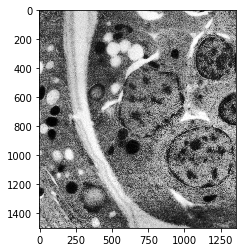

In [2]:
WindowManager = autoclass('ij.WindowManager')

macro = """
#@ String name
open(name);
run("Enhance Contrast...", "saturated=0.3 equalize");
"""

args = {
    'name': '/home/s353960/programs/CSBDeep/Model_Bilder_EM/model_1/SEM/s1_3.png'
}
ij.py.run_macro(macro, args)
EM = WindowManager.getCurrentImage()
print(EM)
ij.py.show(EM, cmap = 'gray')

groundtruth--------------------------------------------------
uint8
8.png: processed
shape: (5392, 10343, 4) to  (256, 256)
 
uint8
10.png: processed
shape: (4296, 9673, 4) to  (256, 256)
 
uint8
1.png: processed
shape: (5221, 9243, 4) to  (256, 256)
 
uint8
6.png: processed
shape: (5445, 9218, 4) to  (256, 256)
 
uint8
7.png: processed
shape: (5609, 10114, 4) to  (256, 256)
 
uint8
9.png: processed
shape: (5009, 9439, 4) to  (256, 256)
 
uint8
3.png: processed
shape: (4841, 5859, 4) to  (256, 256)
 
uint8
4.png: processed
shape: (5150, 8956, 4) to  (256, 256)
 
uint8
5.png: processed
shape: (5491, 9218, 4) to  (256, 256)
 
uint8
2.png: processed
shape: (4246, 7942, 4) to  (256, 256)
 
input--------------------------------------------------------
(3, 5150, 8956)
255.0
float64
float64
uint8
255
(5150, 8956)
4.png: processed
shape: (3, 5150, 8956) to  (2, 256, 256)
 
(3, 4841, 5859)
255.0
float64
float64
uint8
255
(4841, 5859)
3.png: processed
shape: (3, 4841, 5859) to  (2, 256, 256)
 
(

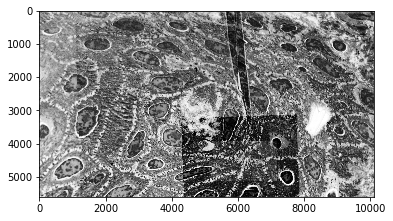

In [20]:
# preprocess images
#------------------------------------------------------------------------------------------------------------------------
# groundtruth

def StackRGB(shape, IM):
    channel2 = shape[2]
    if channel2 <=4: #RGB
        channelofI = IM[:, :, 2] #change channel number if channel for correlation of light microscopic image differs
    else: #stack
        channelofI = IM[0, :, :]
    return channelofI

GTdirectory = '/home/s353960/programs/CSBDeep/Model_Bilder_Christoph/model_2/SIM/'
Xdirectory = '/home/s353960/programs/CSBDeep/Model_Bilder_Christoph/model_2/SIM_normalized_256_test'
os.mkdir(Xdirectory) # comment out if directory exists already

print('groundtruth--------------------------------------------------')
for filename in os.listdir(GTdirectory): #generates list with names of the entries in the directory
    if filename.endswith('.png'): #returns true if string ends with .tif or .tiff
        GTpath = os.path.join(GTdirectory, filename) # join path components intelligently
        IM = imageio.imread(GTpath)
        print(IM.dtype)
        dimension = IM.ndim
        shape = IM.shape
        if dimension >= 3: #RGB image or stack
            channelofI = StackRGB(shape, IM)
        else: # greyscale
            channelofI = IM
        GT = channelofI
        #GT = GT[:925, :] #uncomment if groundtruth image should be cropped [y, x]
        GT = cv2.resize(GT, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        name, ext = os.path.splitext(filename) # split filname in name and extension (ext)
        writepath = os.path.join(Xdirectory, name + '.tif')
        imwrite(writepath, GT)
        print(filename + ': processed')
        text = 'shape: %s to  %s' % (shape, GT.shape)
        print(text)
        print(' ')

#------------------------------------------------------------------------------------------------------------------------
#input
IPdirectory = '/home/s353960/programs/CSBDeep/Model_Bilder_Christoph/model_2/SEM_normalized/'
Ydirectory = '/home/s353960/programs/CSBDeep/Model_Bilder_Christoph/model_2/SEM_normalized_256_test'
os.mkdir(Ydirectory) # comment out if directory exists already
# stack or RGB

def StackRGB(shape, IM):
    channel2 = shape[2]
    if channel2 <=4: #RGB
        channelofI = IM[:, :, 2] #change channel number if channel for correlation of electron microscopic image differs
    else: #stack
        channelofI = IM[0, :, :]
    return channelofI

print('input--------------------------------------------------------')
for filename in os.listdir(IPdirectory): #generates list with names of the entries in the directory
    if filename.endswith('.png'): #returns true if string ends with .tif or .tiff
        IPpath = os.path.join(IPdirectory, filename) # join path components intelligently  
        # equalize histogram with imageJ
        WindowManager = autoclass('ij.WindowManager')
        macro = """
        #@ String name
        open(name);
        run("Enhance Contrast...", "saturated=0.3 equalize");
        """
        args = {
        'name': IPpath
        }
        ij.py.run_macro(macro, args)
        IM = WindowManager.getCurrentImage()
        # ImagePlus object to numpy array
        IM = ij.py.from_java(IM)
        IM = IM.astype(np.uint8)
        IM = IM[0,:]
        dimension = IM.ndim
        if dimension >= 3: #RGB image or stack
            channelofI = StackRGB(shape, IM)
        else: # greyscale
            channelofI = IM
        #channelofI = channelofI[:925, :] #uncomment if input image should be cropped [y, x]
        channelofI = cv2.resize(channelofI, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        IP = np.stack((channelofI, channelofI), axis = 0)
        name, ext = os.path.splitext(filename) # split filname in name and extension (ext)
        writepath = os.path.join(Ydirectory, name + '.tif')
        imwrite(writepath, IP)
        print(filename + ': processed')
        text = 'shape: %s to  %s' % (shape, IP.shape)
        print(text)
        print(' ')

input  image size = (2, 256, 256)
output image size = (256, 256)


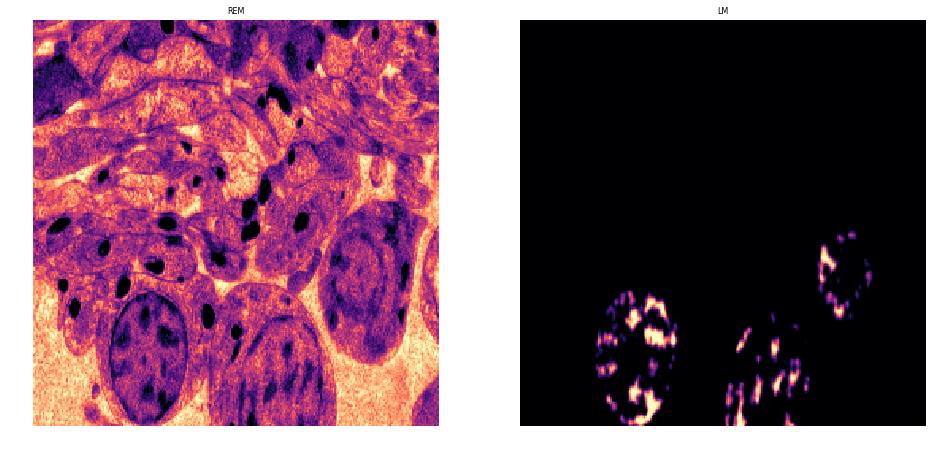

In [74]:
y = imread('/home/s353960/programs/Daten_Elektronenmikroskopie/fluo_input_tif_greyscale/S3.tif') # 16 bit greyscale tif as groundtruth
x = imread('/home/s353960/programs/Daten_Elektronenmikroskopie/rem_input_tifstack_greyscale/S3.tif') # 16 bit greyscale tif stack (2) as input
print('input  image size =', x.shape)
print('output image size =', y.shape)
plt.figure(figsize=(16,10))
plot_some(np.stack([x,np.broadcast_to(y,x.shape)]),
          title_list=[['REM','LM']], 
          pmin=2,pmax=99.8);

In [25]:
raw_data = RawData.from_folder (
    basepath    = '/home/s353960/programs/CSBDeep/Bilder_Christoph/model_2',
    source_dirs = ['SEM_normalized_256'],
    target_dir  = 'fluo_input_tif_greyscale',
    axes        = 'ZYX',
)

In [26]:
X, Y, XY_axes = create_patches_reduced_target (
    raw_data            = raw_data,
    patch_size          = (None,128,128),
    n_patches_per_image = 16,
    target_axes         = 'YX',
    reduction_axes      = 'Z',
    save_file           = '/home/s353960/programs/CSBDeep/Bilder_Christoph/model_2/my_training_data.npz',
)

   10 raw images x    1 transformations   =    10 images
   10 images     x   16 patches per image =   160 patches in total
Input data:
/home/s353960/programs/CSBDeep/Bilder_Christoph/model_2: target='fluo_input_tif_greyscale', sources=['SEM_normalized_256'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Broadcast target image to the shape of source
Patch size:
2 x 128 x 128


100%|██████████| 10/10 [00:00<00:00, 61.84it/s]

Saving data to /home/s353960/programs/CSBDeep/Bilder_Christoph/model_2/my_training_data.npz.


In [27]:
print("shape of X   =", X.shape)
print("shape of Y   =", Y.shape)
print("axes  of X,Y =", XY_axes)

shape of X   = (160, 1, 2, 128, 128)
shape of Y   = (160, 1, 1, 128, 128)
axes  of X,Y = SCZYX


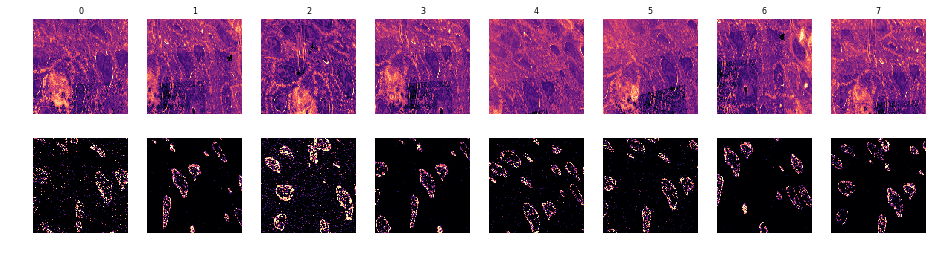

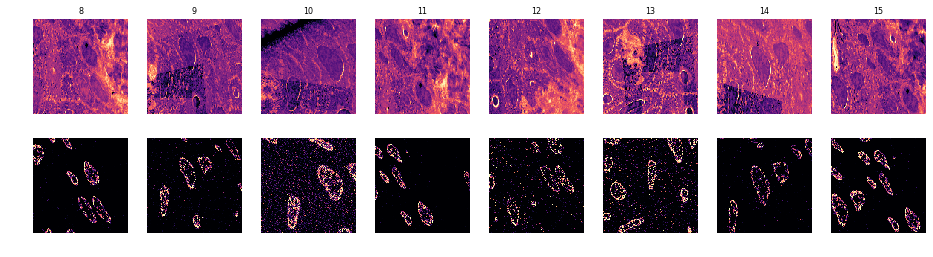

In [28]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;